# Drought Tracks
a. stein, 1.5.2023

Using some similar methodology to [Tracking Atmospheric Rivers Globally: Spatial Distributions and Temporal Evolution of Life Cycle Characteristics](https://agupubs-onlinelibrary-wiley-com.offcampus.lib.washington.edu/doi/full/10.1029/2019JD031205), here I'll be developing tracks using the centroids of the blobs I've connected in the drought network.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.compare as compare
import ndrought.drought_network as dnet

from queue import Queue

/tmp/ipykernel_3086003/4167315774.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/usdm/usdm_WA_net.pickle')
print(usdm_net)

USDM EPSG:4326: DroughtNetwork with D1 threshold, spawned 20-09-2022 12:47:51


## Computing Centroid

Each node had a list of coordinates that make up the blob

In [4]:
test_coords = usdm_net.nodes[0].coords
test_coords

array([[  0, 256],
       [  0, 257],
       [  0, 258],
       ...,
       [ 43, 293],
       [ 43, 294],
       [ 43, 295]])

Computing the centroid without considering the categorical intensity is just a matter of averaging in each axis. 

In [5]:
test_coords.mean(axis=0)

array([ 18.63135135, 285.70432432])

Now if I want to get an unweighted track, I just need to get these centroids across a thread.

## 2015 Drought Track

In [6]:
usdm_net_2015 = usdm_net.get_chronological_future_thread(id=893)

In [7]:
usdm_net_2015_centroids = np.array([node.coords.mean(axis=0) for node in usdm_net_2015])

In [8]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

In [9]:
wa_gdf.geometry.centroid

47    POINT (-120.45228 47.38199)
dtype: geometry

In [10]:
wa_centroid = (-120.45228, 47.38199)

In [11]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')
usdm

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 ...
Attributes:
    compilation:  a. stein, 6/8/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [12]:
lat_min, lat_max = usdm.lat.values.min(), usdm.lat.values.max()
lon_min, lon_max = usdm.lon.values.min(), usdm.lon.values.max()

In [13]:
plt.cm.get_cmap('viridis')(0)

(0.267004, 0.004874, 0.329415, 1.0)

In [14]:
node_times = np.array([node.time for node in usdm_net_2015])
min_time, max_time = node_times.min(), node_times.max()

In [15]:
cmap = plt.cm.get_cmap('viridis')

In [16]:
colors = [cmap((t-min_time)/(max_time-min_time))[:-1] for t in node_times]

<AxesSubplot:>

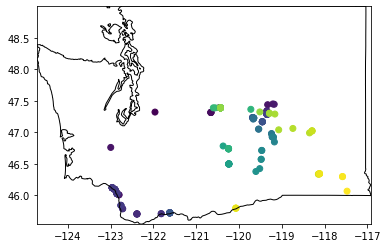

In [17]:
fig, ax = plt.subplots()

ax.scatter(
    ((lon_max-lon_min)/314)*(usdm_net_2015_centroids[:, 1])+lon_min,
    ((lat_min-lat_max)/139)*(usdm_net_2015_centroids[:, 0])+lat_max,
    c=colors
)
ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

wa_gdf.plot(ax=ax, color='None')

Okay, so I'm comparing this with the [animation](/pool0/home/steinadi/data/drought/drought_impact/animations/usdm_thread_893.gif) ... and it retreating to the southeast looks right ... looks like the blips in the southwest are from splits

Can I get arrows plotted instead?

In [18]:
plt.quiver?

Signature: plt.quiver(*args, data=None, **kwargs)
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], **kw)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color.

Each arrow is internally represented by a filled polygon with a default edge
linewidth of 0. As a result, an arrow is rather a filled area, not a line with
a head, and `.PolyCollection` properties like *linewidth*, *linestyle*,
*facecolor*, etc. act accordingly.

**Arrow size**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The defaults give a slightly swept-back arrow; to make the head a
triangle, make *headaxislength* the same as *headlength*. To make the
arrow more pointed, reduce *headwidth* or increase *headlength* and
*headaxislength*. To make the head smaller relative to the shaft,
scale down all the head param

This seems like it'd be easiest with my current setup ... now I just gotta more or less print the network as arrows ... fun ...

In [19]:
usdm_net_2015_dict = {node.id:i for i,node in enumerate(usdm_net_2015)}

In [20]:
def to_lon(x):
    return ((lon_max-lon_min)/314)*(x)+lon_min

In [21]:
def to_lat(y):
    return ((lat_min-lat_max)/139)*(y)+lat_max

In [22]:
x_list = []
y_list = []
u_list = []
v_list = []
color_list = []
alpha_list = []

for node in usdm_net_2015:
    i_node = usdm_net_2015_dict[node.id]
    y, x = usdm_net_2015_centroids[i_node, :]
    x = to_lon(x)
    y = to_lat(y)
    t = node.time
    node_size = len(node.coords)    

    if len(node.future) > 0:
        for future_node in node.future:
            i_future = usdm_net_2015_dict[future_node.id]
            v, u = usdm_net_2015_centroids[i_future, :]

            u = to_lon(u)
            v = to_lat(v)

            x_list.append(x)
            y_list.append(y)

            u_list.append(u-x)
            v_list.append(v-y)

            color_list.append(cmap((t-min_time)/(max_time-min_time))[:-1])

            future_size = len(future_node.coords)

            alpha_list.append(np.min((future_size/node_size, node_size/future_size)))

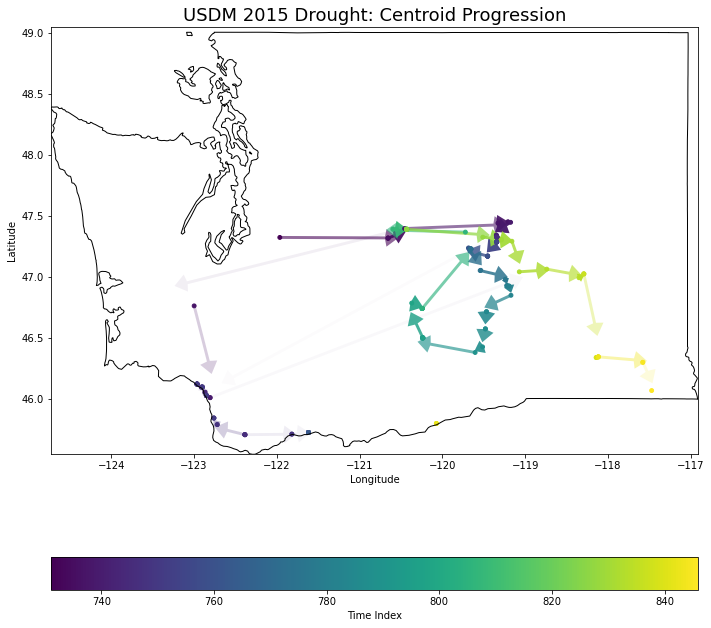

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(
    x_list, y_list, u_list, v_list, color=color_list, 
    scale=1, units='xy', headwidth=6, headlength=4, alpha=alpha_list
)
ax.invert_yaxis()

ax.scatter(
    ((lon_max-lon_min)/314)*(usdm_net_2015_centroids[:, 1])+lon_min,
    ((lat_min-lat_max)/139)*(usdm_net_2015_centroids[:, 0])+lat_max,
    c=colors, s=15
)

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('USDM 2015 Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.colorbar(
    plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=min_time, vmax=max_time), cmap=cmap), 
    ax=ax, orientation='horizontal', label='Time Index'
)

fig.set_facecolor('w')

#ax.axhline(wa_centroid[1])
#ax.axvline(wa_centroid[0])

plt.tight_layout()

Debating whether or not it's worth trimming the other bits ...

Maybe I can adjust their opacity based on an area ratio?

That actually looks pretty decent ... I can now see where it was actually a small offshoot and them coming back into it

Now what if I scale this up the the entire network?

## Origins

In [24]:
usdm_net.origins

[time: 56, id: 0,
 time: 58, id: 2,
 time: 58, id: 4,
 time: 58, id: 5,
 time: 58, id: 6,
 time: 58, id: 7,
 time: 58, id: 8,
 time: 58, id: 9,
 time: 58, id: 10,
 time: 58, id: 11,
 time: 121, id: 369,
 time: 122, id: 371,
 time: 125, id: 376,
 time: 131, id: 382,
 time: 133, id: 386,
 time: 133, id: 387,
 time: 148, id: 389,
 time: 158, id: 400,
 time: 186, id: 406,
 time: 186, id: 407,
 time: 186, id: 408,
 time: 186, id: 409,
 time: 186, id: 410,
 time: 186, id: 411,
 time: 186, id: 412,
 time: 186, id: 413,
 time: 186, id: 414,
 time: 186, id: 415,
 time: 196, id: 479,
 time: 196, id: 481,
 time: 196, id: 482,
 time: 196, id: 483,
 time: 196, id: 484,
 time: 196, id: 485,
 time: 196, id: 486,
 time: 196, id: 487,
 time: 196, id: 488,
 time: 196, id: 489,
 time: 196, id: 490,
 time: 196, id: 491,
 time: 196, id: 492,
 time: 229, id: 525,
 time: 229, id: 526,
 time: 229, id: 528,
 time: 229, id: 529,
 time: 229, id: 530,
 time: 229, id: 531,
 time: 229, id: 532,
 time: 229, id: 533,

In [25]:
usdm_net_centroids = np.array([node.coords.mean(axis=0) for node in usdm_net.origins])

In [26]:
usdm_latlon_centroids = np.vstack(
    (((lon_max-lon_min)/314)*(usdm_net_centroids[:, 1])+lon_min,
    ((lat_min-lat_max)/139)*(usdm_net_centroids[:, 0])+lat_max)
).T

In [27]:
usdm_latlon_centroids

array([[-117.61354666,   48.53561529],
       [-123.063742  ,   48.99804811],
       [-123.02220803,   48.70847976],
       [-122.9593879 ,   48.57114163],
       [-122.63511143,   48.68035027],
       [-123.21326429,   48.67538624],
       [-123.16342353,   48.66297616],
       [-122.70773654,   48.5796514 ],
       [-123.18834391,   48.6009258 ],
       [-122.80623139,   48.54714883],
       [-119.75885955,   45.92035027],
       [-119.25092353,   45.94517041],
       [-119.25092353,   45.94517041],
       [-119.88127804,   45.87489021],
       [-120.67138531,   45.74660926],
       [-120.72122608,   45.72178911],
       [-118.57007609,   47.21899003],
       [-120.07329614,   45.79624955],
       [-123.063742  ,   48.99804811],
       [-120.43260168,   47.38752744],
       [-123.02220803,   48.70847976],
       [-122.9593879 ,   48.57114163],
       [-122.63511143,   48.68035027],
       [-123.21326429,   48.67538624],
       [-123.16342353,   48.66297616],
       [-122.70773654,   

In [28]:
usdm

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 ...
Attributes:
    compilation:  a. stein, 6/8/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [29]:
colors = [cmap((origin.time/1163))[:-1] for origin in usdm_net.origins]

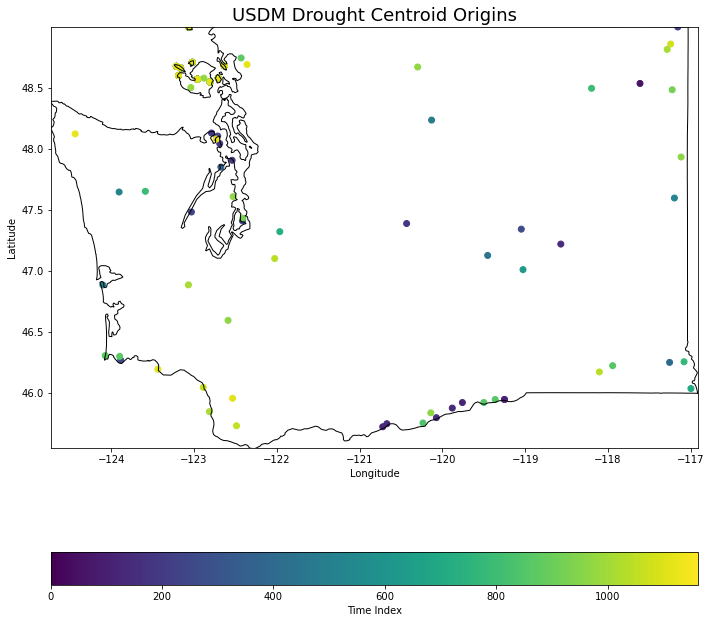

In [30]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(
    usdm_latlon_centroids[:, 0],
    usdm_latlon_centroids[:, 1],
    c=colors
)
ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

wa_gdf.plot(ax=ax, color='None')

fig.colorbar(
    plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1163), cmap=cmap), 
    ax=ax, orientation='horizontal', label='Time Index'
)

ax.set_title('USDM Drought Centroid Origins', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

Not feeling any discernable pattern here

## All Drought Tracks

So to get all the tracks ... I need all the connections ... WAIT, I HAVE AN ADJACENCY DICTIONARY!

In [31]:
usdm_net.adj_dict

{0: [1],
 1: [3],
 2: [12],
 3: [13],
 4: [14],
 5: [15],
 6: [16],
 7: [17],
 8: [18],
 9: [19],
 10: [20],
 11: [21],
 12: [22],
 13: [23],
 14: [24],
 15: [25],
 16: [26],
 17: [27],
 18: [28],
 19: [29],
 20: [30],
 21: [31],
 22: [32],
 23: [33],
 24: [34],
 25: [35],
 26: [36],
 27: [37],
 28: [38],
 29: [39],
 30: [40],
 31: [41],
 32: [42],
 33: [43],
 34: [44],
 35: [45],
 36: [46],
 37: [47],
 38: [48],
 39: [49],
 40: [50],
 41: [51],
 42: [52],
 43: [53],
 44: [54],
 45: [55],
 46: [56],
 47: [57],
 48: [58],
 49: [59],
 50: [60],
 51: [61],
 52: [62],
 53: [63],
 54: [64],
 55: [65],
 56: [66],
 57: [67],
 58: [68],
 59: [69],
 60: [70],
 61: [71],
 62: [72],
 63: [73],
 64: [74],
 65: [75],
 66: [76],
 67: [77],
 68: [78],
 69: [79],
 70: [80],
 71: [81],
 72: [82],
 73: [83],
 74: [84],
 75: [85],
 76: [86],
 77: [87],
 78: [88],
 79: [89],
 80: [90],
 81: [91],
 82: [92],
 83: [93],
 84: [94],
 85: [95],
 86: [96],
 87: [97],
 88: [98],
 89: [99],
 90: [100],
 91: [101]

And I can pull up nodes

In [32]:
usdm_net.find_node_by_id(873)

time: 652, id: 873

I feel like there has got to be some better way then what I'm about to do ... but I don't know otherwise right now

Let's compute all the centroids separately then link them together ... I think that'd reduce total computations/simplify things

In [33]:
def to_latlon(coord):
    y, x = coord
    return (to_lon(x), to_lat(y))

In [34]:
usdm_net_centroids = {node.id:(*to_latlon(node.coords.mean(axis=0)), node.time, len(node.coords)) for node in usdm_net.nodes}

In [35]:
usdm_net_centroids

{0: (-117.61354665793345, 48.535615285681395, 56, 1850),
 1: (-117.61354665793345, 48.535615285681395, 57, 1850),
 2: (-123.06374200136604, 48.99804810699192, 58, 3),
 3: (-120.43626155977374, 47.38919086130467, 58, 33522),
 4: (-123.02220803109003, 48.70847976166817, 58, 3),
 5: (-122.95938790104758, 48.57114163217177, 58, 80),
 6: (-122.63511142811764, 48.6803502652653, 58, 5),
 7: (-123.21326429435967, 48.67538623648832, 58, 1),
 8: (-123.16342353002847, 48.662976164545874, 58, 2),
 9: (-122.7077365418574, 48.57965139578945, 58, 7),
 10: (-123.18834391219407, 48.60092580483364, 58, 1),
 11: (-122.8062313856548, 48.547148826416375, 58, 6),
 12: (-123.06374200136604, 48.99804810699192, 59, 3),
 13: (-120.43413504423029, 47.388220647907495, 59, 33546),
 14: (-123.02220803109003, 48.70847976166817, 59, 3),
 15: (-122.95938790104758, 48.57114163217177, 59, 80),
 16: (-122.63511142811764, 48.6803502652653, 59, 5),
 17: (-123.21326429435967, 48.67538623648832, 59, 1),
 18: (-123.1634235300

In [36]:
x_tracks = []
y_tracks = []
u_tracks = []
v_tracks = []
color_tracks = []
alpha_tracks = []


for origin in usdm_net.origins:

    # the ones that are one-off events I don't want to plot
    if len(origin.future) > 0:

        thread_ids = [origin.id]

        x_list = []
        y_list = []
        u_list = []
        v_list = []
        t_list = []
        alpha_list = []

        while len(thread_ids) > 0:
            current_id = thread_ids[0]

            future_ids = usdm_net.adj_dict[current_id]
            thread_ids = [*thread_ids, *future_ids]
            thread_ids = thread_ids[1:]

            x, y, t, s = usdm_net_centroids[current_id]
            
            if len(future_ids) > 0:
                for future_id in future_ids:
                    u, v, __, s_f = usdm_net_centroids[future_id]

                    x_list.append(x)
                    y_list.append(y)
                    u_list.append(u-x)
                    v_list.append(v-y)
                    t_list.append(t)

                    alpha_list.append(np.min((s_f/s, s/s_f)))

        t_min = np.min(t_list)
        t_max = np.max(t_list)
        color_list = [cmap((t-t_min)/(t_max-t_min))[:-1] for t in t_list]

        x_tracks.append(x_list)
        y_tracks.append(y_list)
        u_tracks.append(u_list)
        v_tracks.append(v_list)
        color_tracks.append(color_list)
        alpha_tracks.append(alpha_list)
                

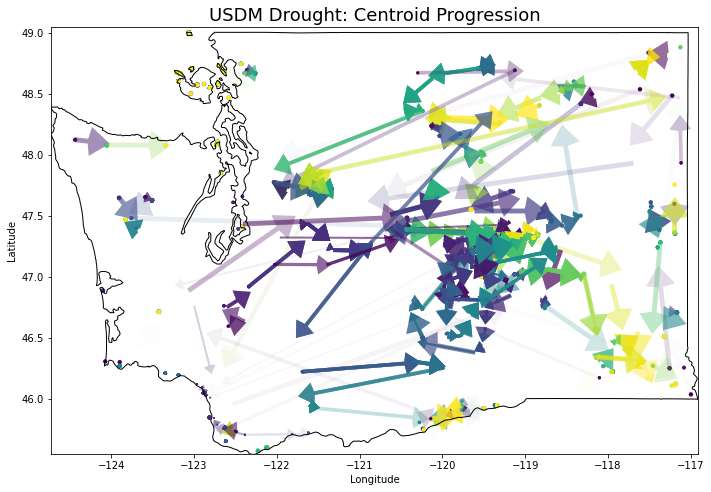

In [37]:
fig, ax = plt.subplots(figsize=(10,10))

for x_list, y_list, u_list, v_list, color_list, alpha_list in zip(x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks):

    ax.quiver(
        x_list, y_list, u_list, v_list, color=color_list, 
        scale=1, units='xy', headwidth=6, headlength=4, alpha=alpha_list
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('USDM Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

Fascinating

Can I plot the displacements?

In [38]:
displacement = [np.sqrt((u**2) + (v**2)) for u, v in zip(np.hstack(u_tracks), np.hstack(v_tracks))]

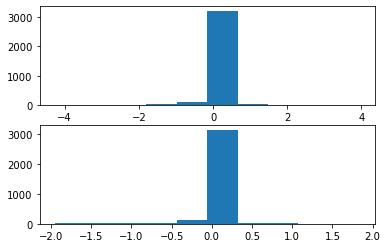

In [39]:
fig, ax = plt.subplots(2,1)

ax[0].hist(np.hstack(u_tracks));
ax[1].hist(np.hstack(v_tracks));

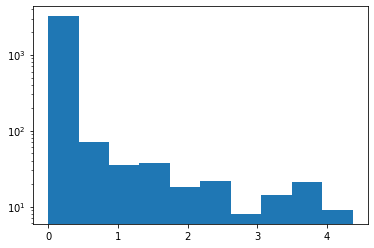

In [40]:
fig, ax = plt.subplots()

ax.hist(displacement);
ax.set_yscale('log')

Now, these are lat/lon changes, which doesn't make full sense to compute in a euclidean manner, but still fun

Okay, lets put this in a function then run it for some other metrics

In [41]:
def to_lat(y, lat_meta):
    lat_min, lat_max, lat_spacing = lat_meta
    return ((lat_min-lat_max)/lat_spacing)*(y)+lat_max

def to_lon(x, lon_meta):
    lon_min, lon_max, lon_spacing = lon_meta
    return ((lon_max-lon_min)/lon_spacing)*(x)+lon_min

def to_latlon(coord, coord_meta):
    lat_min, lat_max, lat_spacing, lon_min, lon_max, lon_spacing = coord_meta

    lat_meta = (lat_min, lat_max, lat_spacing)
    lon_meta = (lon_min, lon_max, lon_spacing)

    y, x = coord
    return (to_lon(x, lon_meta), to_lat(y, lat_meta))


def extract_drought_tracks(net, coord_meta, cmap=plt.cm.get_cmap('viridis'), s_thresh=0):

    net_centroids = {node.id:(*to_latlon(node.coords.mean(axis=0), coord_meta), node.time, len(node.coords)) for node in net.nodes}

    x_tracks = []
    y_tracks = []
    u_tracks = []
    v_tracks = []
    color_tracks = []
    alpha_tracks = []

    computed_ids = []


    for origin in tqdm(net.origins):

        # the ones that are one-off events I don't want to plot
        if len(origin.future) > 0:
            #print('thread starting ...')

            thread_ids = [origin.id]

            x_list = []
            y_list = []
            u_list = []
            v_list = []
            t_list = []
            alpha_list = []

            while len(thread_ids) > 0:
                
                current_id = thread_ids.pop(0)
                if not current_id in computed_ids:
                    computed_ids.append(current_id)
            
                    future_ids = net.adj_dict[current_id]
                    thread_ids = [*thread_ids, *future_ids]
                    

                    x, y, t, s = net_centroids[current_id]

                    if len(computed_ids) > len(net.nodes):
                        return computed_ids

                    #print(len(thread_ids), current_id, t, len(computed_ids), len(future_ids))
                    
                    if s > s_thresh and len(future_ids) > 0:
                        for future_id in future_ids:
                            u, v, __, s_f = net_centroids[future_id]

                            x_list.append(x)
                            y_list.append(y)
                            u_list.append(u-x)
                            v_list.append(v-y)
                            t_list.append(t)

                            alpha_list.append(np.min((s_f/s, s/s_f)))
                


            #print('exit while loop')
            if len(t_list) > 0:
                #print('thread added')
                t_min = np.min(t_list)
                t_max = np.max(t_list)
                color_list = [cmap((t-t_min)/(t_max-t_min))[:-1] for t in t_list]

                x_tracks.append(x_list)
                y_tracks.append(y_list)
                u_tracks.append(u_list)
                v_tracks.append(v_list)
                color_tracks.append(color_list)
                alpha_tracks.append(alpha_list)

        #else:
            #print('not a thread')

    return x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks
                    

In [42]:
track_tup = extract_drought_tracks(
    usdm_net,
    (lat_min, lat_max, 139, lon_min, lon_max, 314)
)

  0%|          | 0/172 [00:00<?, ?it/s]

In [43]:
x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks = track_tup

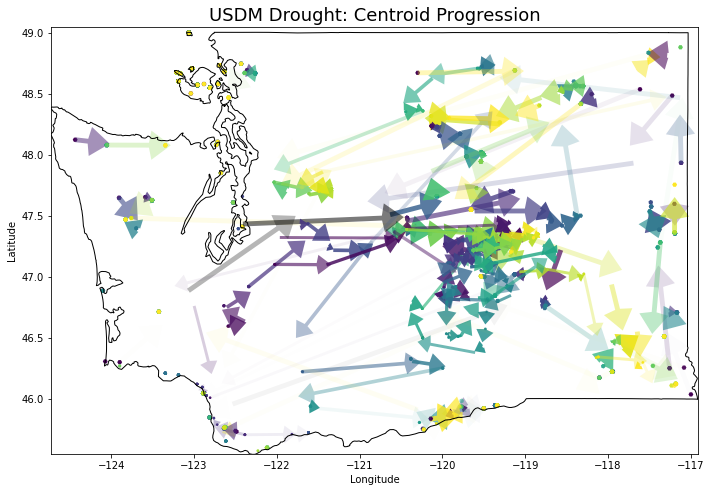

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

for x_list, y_list, u_list, v_list, color_list, alpha_list in zip(x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks):

    ax.quiver(
        x_list, y_list, u_list, v_list, color=color_list, 
        scale=1, units='xy', headwidth=6, headlength=4, alpha=alpha_list
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('USDM Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

Wonderful, get the same thing out

## PDSI Track

In [45]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')
pdsi

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Data variables:
    crs      int64 ...
    pdsi     (day, lat, lon) float32 ...
Attributes:
    author:       a. stein, 7/28/2022
    description:  Palmer Drought Severity Index (PDSI) gathered from various ...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

In [46]:
pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle')

In [47]:
pdsi_tracks = extract_drought_tracks(
    pdsi_net,
    (
        pdsi.lat.values.min(), pdsi.lat.values.max(), 84, 
        pdsi.lon.values.min(), pdsi.lon.values.max(), 188
    ),
    s_thresh=20
)

  0%|          | 0/5668 [00:00<?, ?it/s]

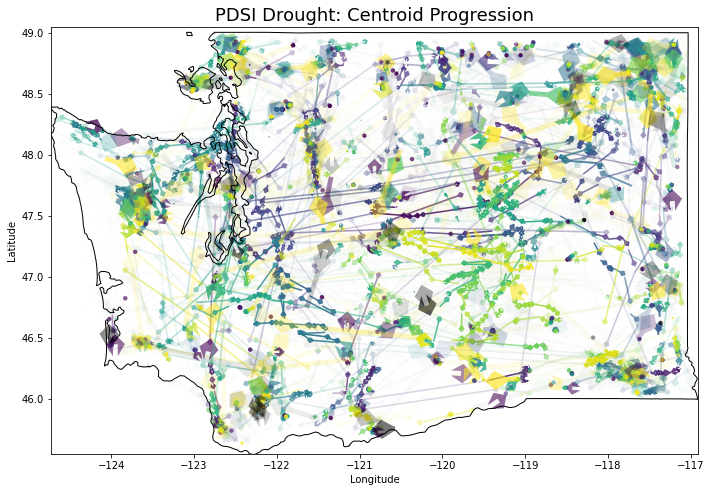

In [48]:
x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks = pdsi_tracks

fig, ax = plt.subplots(figsize=(10,10))

for x_list, y_list, u_list, v_list, color_list, alpha_list in zip(x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks):

    ax.quiver(
        x_list, y_list, u_list, v_list, color=color_list, 
        scale=1, units='xy', headwidth=4, headlength=2, alpha=alpha_list
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('PDSI Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

Okay ... since I'm only going through each set of connections once, a lot of them appear to be terminating but I think are just joining into others. 

How am I then defining termination?

Like I know it ends if there are no nodes it connects to ... but how do I match up genesis (to use the article's terms) to termination?

In [49]:
pdsi_net.origins

[time: 0, id: 0,
 time: 1, id: 2,
 time: 1, id: 3,
 time: 1, id: 4,
 time: 17, id: 45,
 time: 22, id: 53,
 time: 28, id: 65,
 time: 32, id: 72,
 time: 34, id: 79,
 time: 36, id: 89,
 time: 38, id: 99,
 time: 40, id: 108,
 time: 41, id: 111,
 time: 43, id: 118,
 time: 43, id: 119,
 time: 44, id: 128,
 time: 46, id: 136,
 time: 46, id: 137,
 time: 46, id: 141,
 time: 46, id: 142,
 time: 46, id: 145,
 time: 47, id: 149,
 time: 47, id: 150,
 time: 47, id: 151,
 time: 47, id: 154,
 time: 47, id: 156,
 time: 48, id: 158,
 time: 48, id: 159,
 time: 48, id: 160,
 time: 48, id: 161,
 time: 48, id: 162,
 time: 48, id: 163,
 time: 48, id: 164,
 time: 48, id: 165,
 time: 48, id: 167,
 time: 48, id: 169,
 time: 48, id: 171,
 time: 48, id: 173,
 time: 49, id: 177,
 time: 49, id: 180,
 time: 49, id: 181,
 time: 49, id: 182,
 time: 49, id: 186,
 time: 49, id: 187,
 time: 49, id: 191,
 time: 49, id: 193,
 time: 49, id: 194,
 time: 49, id: 196,
 time: 49, id: 200,
 time: 49, id: 201,
 time: 49, id: 207,

pdsi_net.get_chronological_future_thread(pdsi_net.origins[6].id)

In [50]:
def net_crawl(id):
    future_ids = pdsi_net.adj_dict[id]
    for future in future_ids:
        net_crawl(future)

net_crawl(pdsi_net.origins[6].id)

In [51]:
for node in pdsi_net.nodes:
    for future in node.future:
        if future.time <= node.time:
            print(node, future)

In [52]:
def bfs(node):
    q = Queue()
    q.put(node)
    thread_computed = [node.id]

    while not q.empty():
        current_node = q.get()
        
        #print(current_node.id, thread_computed)

        for future in current_node.future:
            if not future.id in thread_computed:
                q.put(future)
                thread_computed.append(future.id)

In [53]:
len(pdsi_net.nodes)

39327

In [54]:
bfs(pdsi_net.origins[0])

In [55]:
bfs(pdsi_net.origins[6])

In [56]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

In [57]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

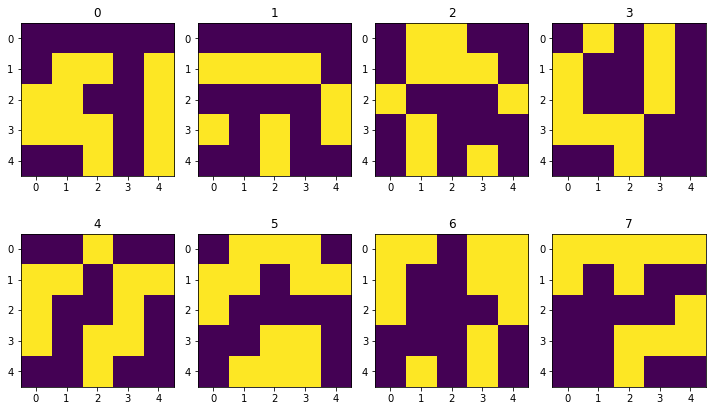

In [58]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

In [59]:
test_net = dnet.DroughtNetwork(np.array(test_series))

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [60]:
bfs(test_net.origins[0])

In [61]:
def to_lat(y, lat_meta):
    lat_min, lat_max, lat_spacing = lat_meta
    return ((lat_min-lat_max)/lat_spacing)*(y)+lat_max

def to_lon(x, lon_meta):
    lon_min, lon_max, lon_spacing = lon_meta
    return ((lon_max-lon_min)/lon_spacing)*(x)+lon_min

def to_latlon(coord, coord_meta):
    lat_min, lat_max, lat_spacing, lon_min, lon_max, lon_spacing = coord_meta

    lat_meta = (lat_min, lat_max, lat_spacing)
    lon_meta = (lon_min, lon_max, lon_spacing)

    y, x = coord
    return (to_lon(x, lon_meta), to_lat(y, lat_meta))


def extract_drought_tracks(net, coord_meta, cmap=plt.cm.get_cmap('viridis'), s_thresh=0):

    net_centroids = {node.id:(*to_latlon(node.coords.mean(axis=0), coord_meta), node.time, len(node.coords)) for node in net.nodes}

    x_tracks = []
    y_tracks = []
    u_tracks = []
    v_tracks = []
    color_tracks = []
    alpha_tracks = []


    for origin in tqdm(net.origins):

        # the ones that are one-off events I don't want to plot
        if len(origin.future) > 0:
            x_list = []
            y_list = []
            u_list = []
            v_list = []
            t_list = []
            alpha_list = []

            q = Queue()
            q.put(origin.id)
            thread_ids = [origin.id]

            while not q.empty():
                
                #current_id = thread_ids.pop(0)
                current_id = q.get()

                for future_id in net.adj_dict[current_id]:
                    if not future_id in thread_ids:
                        q.put(future_id)
                        thread_ids.append(future_id)
                                
                        x, y, t, s = net_centroids[current_id]
                        
                        if s > s_thresh:
                            u, v, __, s_f = net_centroids[future_id]

                            x_list.append(x)
                            y_list.append(y)
                            u_list.append(u-x)
                            v_list.append(v-y)
                            t_list.append(t)

                            alpha_list.append(np.min((s_f/s, s/s_f)))
                
            if len(t_list) > 0:
                t_min = np.min(t_list)
                t_max = np.max(t_list)
                color_list = [cmap((t-t_min)/(t_max-t_min))[:-1] for t in t_list]

                x_tracks.append(x_list)
                y_tracks.append(y_list)
                u_tracks.append(u_list)
                v_tracks.append(v_list)
                color_tracks.append(color_list)
                alpha_tracks.append(alpha_list)


    return x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks
                    

In [62]:
track_tup = extract_drought_tracks(
    usdm_net,
    (lat_min, lat_max, 139, lon_min, lon_max, 314)
)

  0%|          | 0/172 [00:00<?, ?it/s]

In [63]:
x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks = track_tup

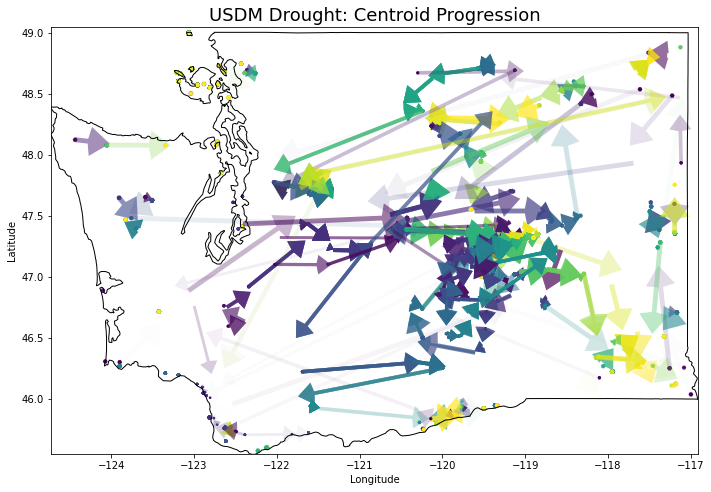

In [64]:
fig, ax = plt.subplots(figsize=(10,10))

for x_list, y_list, u_list, v_list, color_list, alpha_list in zip(x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks):

    ax.quiver(
        x_list, y_list, u_list, v_list, color=color_list, 
        scale=1, units='xy', headwidth=6, headlength=4, alpha=alpha_list
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('USDM Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

In [65]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')
pdsi

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Data variables:
    crs      int64 ...
    pdsi     (day, lat, lon) float32 ...
Attributes:
    author:       a. stein, 7/28/2022
    description:  Palmer Drought Severity Index (PDSI) gathered from various ...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

In [66]:
pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle')

In [67]:
pdsi_tracks = extract_drought_tracks(
    pdsi_net,
    (
        pdsi.lat.values.min(), pdsi.lat.values.max(), 84, 
        pdsi.lon.values.min(), pdsi.lon.values.max(), 188
    ),
    s_thresh=20
)

  0%|          | 0/5668 [00:00<?, ?it/s]

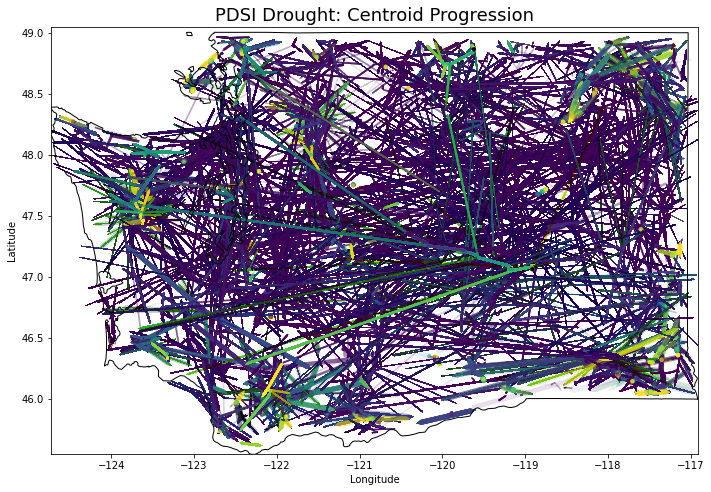

In [ ]:
x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks = pdsi_tracks

fig, ax = plt.subplots(figsize=(10,10))

for x_list, y_list, u_list, v_list, color_list, alpha_list in zip(x_tracks, y_tracks, u_tracks, v_tracks, color_tracks, alpha_tracks):

    ax.quiver(
        x_list, y_list, u_list, v_list, color=color_list, 
        scale=1, units='xy', headwidth=1, headlength=1, alpha=alpha_list
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('PDSI Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

Okay, so we need to find a way to clean this up

In [ ]:
len(x_tracks)

4181

In [ ]:
len(pdsi_net.origins)

5668

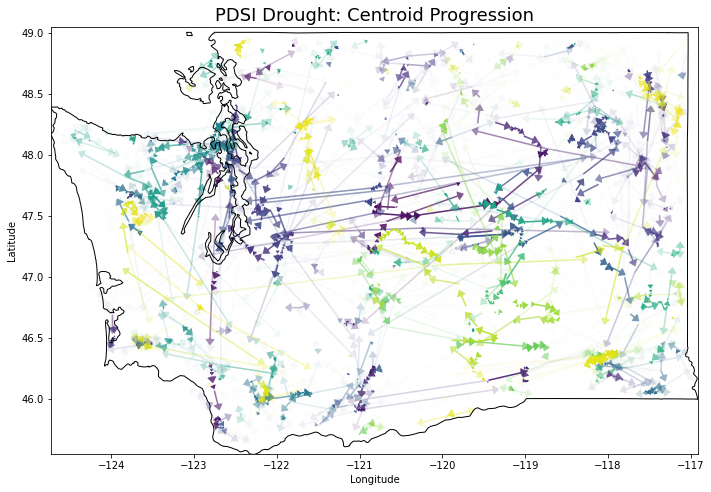

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

i = 5

ax.quiver(
        x_tracks[i], y_tracks[i], u_tracks[i], v_tracks[i], color=color_tracks[i], 
        scale=1, units='xy', headwidth=6, headlength=4, alpha=alpha_tracks[i]
    )

ax.invert_yaxis()

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max*1.001)

wa_gdf.plot(ax=ax, color='None')

ax.set_title('PDSI Drought: Centroid Progression', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

fig.set_facecolor('w')

plt.tight_layout()

let's poke at the origins

In [ ]:
pdsi_coord_meta = (pdsi.lat.values.min(), pdsi.lat.values.max(), 84,pdsi.lon.values.min(), pdsi.lon.values.max(), 188
)

In [ ]:
pdsi_net_centroids = {node.id:(*to_latlon(node.coords.mean(axis=0), pdsi_coord_meta), node.time, len(node.coords)) for node in pdsi_net.nodes}

In [ ]:
pdsi_origin_centroids = []

for origin in pdsi_net.origins:
    pdsi_origin_centroids.append(pdsi_net_centroids[origin.id])

pdsi_origin_centroids = np.vstack(pdsi_origin_centroids)

In [ ]:
pdsi_origin_centroids

array([[-1.19378173e+02,  4.65445142e+01,  0.00000000e+00,
         1.38900000e+03],
       [-1.19834486e+02,  4.74600198e+01,  1.00000000e+00,
         1.00000000e+00],
       [-1.20580496e+02,  4.70483135e+01,  1.00000000e+00,
         1.00000000e+00],
       ...,
       [-1.19585816e+02,  4.86951389e+01,  1.14600000e+03,
         1.00000000e+00],
       [-1.19544371e+02,  4.84892857e+01,  1.14600000e+03,
         1.00000000e+00],
       [-1.18591135e+02,  4.81599206e+01,  1.14600000e+03,
         1.00000000e+00]])

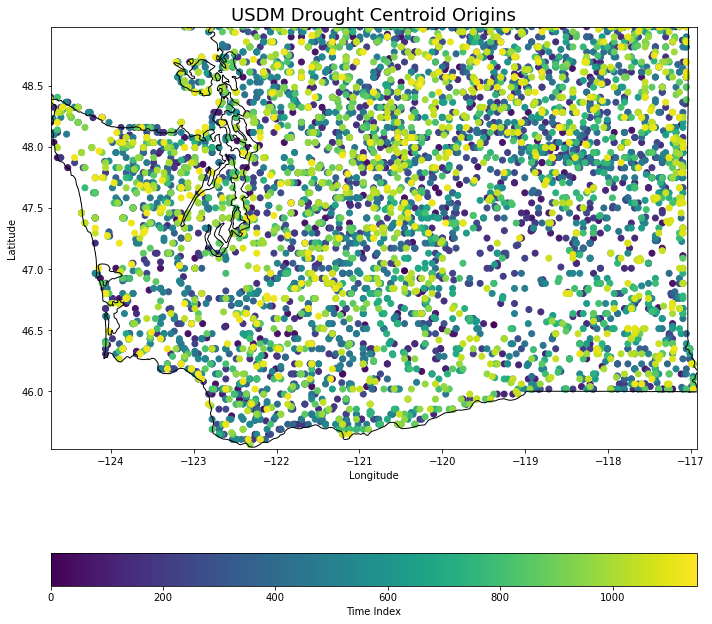

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(
    pdsi_origin_centroids[:, 0],
    pdsi_origin_centroids[:, 1],
    c=[cmap(t/1149)[:-1] for t in pdsi_origin_centroids[:, 2]]
)
ax.invert_yaxis()

ax.set_xlim(pdsi_coord_meta[3], pdsi_coord_meta[4])
ax.set_ylim(pdsi_coord_meta[0], pdsi_coord_meta[1])

wa_gdf.plot(ax=ax, color='None')

fig.colorbar(
    plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1149), cmap=cmap), 
    ax=ax, orientation='horizontal', label='Time Index'
)

ax.set_title('USDM Drought Centroid Origins', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

Okay, no noticeable origin pattern, what about termination?

I'm going to need to do a depth-first-search to probably be most efficient

In [ ]:
def dfs(node):
    searchable_nodes = [node]
    computed_nodes = [node.id]

    while len(searchable_nodes) > 0:
        current_node = searchable_nodes.pop()

        for future in current_node.future:
            if not future.id in computed_nodes:
                searchable_nodes.append(future)
                computed_nodes.append(future.id)

for origin in tqdm(pdsi_net.origins):
    dfs(origin)

Okay, that looks like it'll run just fine, just will take some time.

The only heuristic I can think of to speed things up would be to follow the ones with the greatest area ... but that still would be a bias imposed on my behalf ... but might be needed ... tbd

In [ ]:
def find_termination_nodes(node):
    searchable_nodes = [node]
    computed_nodes = [node.id]
    termination_nodes = []

    while len(searchable_nodes) > 0:
        current_node = searchable_nodes.pop()
        if len(current_node.future) == 0:
            termination_nodes.append(current_node)
        else:
            for future in current_node.future:
                if not future.id in computed_nodes:
                    searchable_nodes.append(future)
                    computed_nodes.append(future.id)

    return termination_nodes

In [ ]:
pdsi_termination_nodes = []

for origin in tqdm(pdsi_net.origins):
    # I'm still not interested in one-off events
    if len(origin.future) != 0:
        pdsi_termination_nodes.append(np.array(find_termination_nodes(origin)))

  0%|          | 0/5668 [00:00<?, ?it/s]

In [ ]:
pdsi_termination_nodes

[array([time: 3, id: 12, time: 6, id: 17, time: 7, id: 19, time: 8, id: 21,
        time: 39, id: 102, time: 9, id: 27, time: 10, id: 35,
        time: 10, id: 34, time: 10, id: 32, time: 11, id: 39,
        time: 10, id: 33, time: 10, id: 31, time: 10, id: 30,
        time: 10, id: 29], dtype=object),
 array([time: 2, id: 6], dtype=object),
 array([time: 3, id: 10], dtype=object),
 array([time: 4, id: 14], dtype=object),
 array([time: 19, id: 49], dtype=object),
 array([time: 26, id: 61], dtype=object),
 array([time: 70, id: 908, time: 74, id: 1071, time: 76, id: 1135, ...,
        time: 70, id: 897, time: 70, id: 895, time: 71, id: 922],
       dtype=object),
 array([time: 70, id: 908, time: 74, id: 1071, time: 76, id: 1135, ...,
        time: 70, id: 897, time: 70, id: 895, time: 71, id: 922],
       dtype=object),
 array([time: 37, id: 92], dtype=object),
 array([time: 53, id: 305], dtype=object),
 array([time: 46, id: 144], dtype=object),
 array([time: 44, id: 124], dtype=object),

In [ ]:
pdsi_termination_centroids = []

for thread in pdsi_termination_nodes:
    thread_centroids = []
    for node in thread:
        thread_centroids.append(pdsi_net_centroids[node.id])
    pdsi_termination_centroids.append(thread_centroids)

In [ ]:
pdsi_centroid_plots = []

for thread in pdsi_termination_centroids:
    for centroid_data in thread:
        pdsi_centroid_plots.append((centroid_data[0], centroid_data[1]))

In [ ]:
fig, ax = plt.subplots()

for thread in pdsi_termination_centroids:
    for centroid_data in thread:
        ax.scatter(centroid_data[0], centroid_data[1])

ax.invert_yaxis()

ax.set_xlim(pdsi_coord_meta[3], pdsi_coord_meta[4])
ax.set_ylim(pdsi_coord_meta[0], pdsi_coord_meta[1])

wa_gdf.plot(ax=ax, color='None')

fig.colorbar(
    plt.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=1149), cmap=cmap), 
    ax=ax, orientation='horizontal', label='Time Index'
)

ax.set_title('USDM Drought Centroid Terminations', fontsize=18)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.tight_layout()

KeyboardInterrupt: 